# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

Utils has a solid API for building these modular frameworks and training them, and we will use this very well implemented framework as opposed to "reinventing the wheel."  This includes using the Solver, various utility functions, and the layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [14]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print(  )

Running tests with p =  0.3
Mean of input:  10.002898472632062
Mean of train-time output:  10.025619592528209
Mean of test-time output:  10.002898472632062
Fraction of train-time output set to zero:  0.699396
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.002898472632062
Mean of train-time output:  10.015838393782959
Mean of test-time output:  10.002898472632062
Fraction of train-time output set to zero:  0.399256
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.002898472632062
Mean of train-time output:  10.015224946990443
Mean of test-time output:  10.002898472632062
Fraction of train-time output set to zero:  0.248928
Fraction of test-time output set to zero:  0.0



## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [15]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.4456104932567176e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [17]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0.5, 0.75, 1.0]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              weight_scale=5e-2, dtype=np.float64,
                              dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    print('\n')

Running check with dropout =  0.5
Initial loss:  2.3050396176612384
W1 relative error: 7.839091367974606e-07
W2 relative error: 2.5656696352835975e-07
W3 relative error: 7.66140281048889e-08
b1 relative error: 4.461314594443551e-09
b2 relative error: 7.630256229692641e-10
b3 relative error: 1.7671730210721276e-10


Running check with dropout =  0.75
Initial loss:  2.2924165725936616
W1 relative error: 1.913764152741491e-07
W2 relative error: 1.3174644422188826e-07
W3 relative error: 3.246749313511893e-07
b1 relative error: 7.519165775969613e-09
b2 relative error: 1.9613765149833703e-09
b3 relative error: 1.4849637974979418e-10


Running check with dropout =  1.0
Initial loss:  2.3055208155971316
W1 relative error: 5.474025246189813e-07
W2 relative error: 7.600892283230569e-08
W3 relative error: 4.657460911645141e-08
b1 relative error: 6.88212284937315e-09
b2 relative error: 1.5631103560839323e-09
b3 relative error: 1.6519207248783954e-10




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [42]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0.6, 1.0]
for dropout in dropout_choices:
    model = FullyConnectedNet([100, 100, 100], dropout=dropout)

    solver = Solver(model, small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 5e-4,
                    },
                    verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.299614
(Epoch 0 / 25) train acc: 0.158000; val_acc: 0.155000
(Epoch 1 / 25) train acc: 0.162000; val_acc: 0.162000
(Epoch 2 / 25) train acc: 0.254000; val_acc: 0.231000
(Epoch 3 / 25) train acc: 0.298000; val_acc: 0.256000
(Epoch 4 / 25) train acc: 0.344000; val_acc: 0.284000
(Epoch 5 / 25) train acc: 0.342000; val_acc: 0.264000
(Epoch 6 / 25) train acc: 0.416000; val_acc: 0.297000
(Epoch 7 / 25) train acc: 0.458000; val_acc: 0.299000
(Epoch 8 / 25) train acc: 0.472000; val_acc: 0.309000
(Epoch 9 / 25) train acc: 0.558000; val_acc: 0.310000
(Epoch 10 / 25) train acc: 0.610000; val_acc: 0.323000
(Epoch 11 / 25) train acc: 0.610000; val_acc: 0.292000
(Epoch 12 / 25) train acc: 0.658000; val_acc: 0.322000
(Epoch 13 / 25) train acc: 0.732000; val_acc: 0.313000
(Epoch 14 / 25) train acc: 0.752000; val_acc: 0.290000
(Epoch 15 / 25) train acc: 0.792000; val_acc: 0.324000
(Epoch 16 / 25) train acc: 0.818000; val_acc: 0.303000
(Epoch 17 / 25) train acc: 0.848000; val

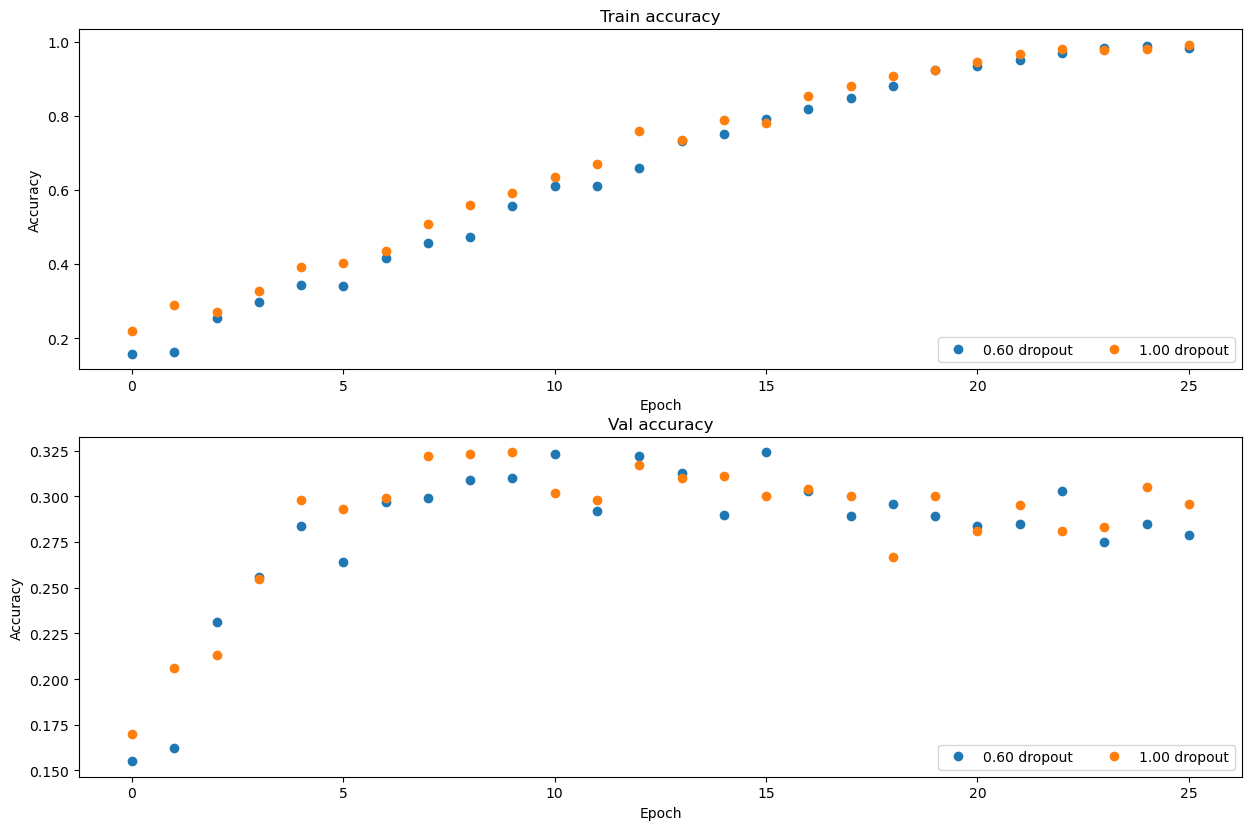

In [43]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:

I think here dropout's impact is not obvious considering we only trained on 500 data. The training accuracy is almost 100% but the validation accuracy is only about 30%. It implies that our model is seriously overfitting and we do need dropout.

I changed the dropout from [0.6, 1.0] to [0.2, 1.0]. The results showed that model still achieved nearly 100% on training accuracy, but on validation accuracy with dropout the network performed better obviously compared to network without dropout.

Then I changed the num_train to 5000 and tested it again. The result showed that with/without dropout the training accuracy still nearly to 90%. But on validation data, with dropout the network performed better (not too much though). 

Therefore we could say that dropout's capability: it could help to increase our model's generalization and prevent the overfitting at some extent. 


##### Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 23%, 1) 
where if you get 55% or higher validation accuracy, you get full points.

In [50]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #
optimizer = 'adam'
dropout=0.6
layer_dims = [500, 500, 500]
weight_scale = 0.01
learning_rate = 1e-3
lr_decay = 0.9

model = FullyConnectedNet(layer_dims, weight_scale=weight_scale,
                          use_batchnorm=True, dropout = dropout)

solver = Solver(model, data,
                num_epochs=10, batch_size=100,
                update_rule=optimizer,
                optim_config={
                  'learning_rate': learning_rate,
                },
                lr_decay=lr_decay,
                verbose=True, print_every=50)
solver.train()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


(Iteration 1 / 4900) loss: 2.335502
(Epoch 0 / 10) train acc: 0.155000; val_acc: 0.166000
(Iteration 51 / 4900) loss: 1.886194
(Iteration 101 / 4900) loss: 1.833522
(Iteration 151 / 4900) loss: 1.899841
(Iteration 201 / 4900) loss: 1.610528
(Iteration 251 / 4900) loss: 1.404449
(Iteration 301 / 4900) loss: 1.631404
(Iteration 351 / 4900) loss: 1.855381
(Iteration 401 / 4900) loss: 1.708536
(Iteration 451 / 4900) loss: 1.649088
(Epoch 1 / 10) train acc: 0.447000; val_acc: 0.449000
(Iteration 501 / 4900) loss: 1.621702
(Iteration 551 / 4900) loss: 1.495131
(Iteration 601 / 4900) loss: 1.505964
(Iteration 651 / 4900) loss: 1.464100
(Iteration 701 / 4900) loss: 1.504684
(Iteration 751 / 4900) loss: 1.487932
(Iteration 801 / 4900) loss: 1.551561
(Iteration 851 / 4900) loss: 1.412798
(Iteration 901 / 4900) loss: 1.461804
(Iteration 951 / 4900) loss: 1.455468
(Epoch 2 / 10) train acc: 0.496000; val_acc: 0.482000
(Iteration 1001 / 4900) loss: 1.543609
(Iteration 1051 / 4900) loss: 1.407979
(It

In [51]:
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))

Validation set accuracy: 0.58
Test set accuracy: 0.564
